# First we will run experiments on using six landmarks only. We will use the folds that were created. 
# We will edit these parameters to see what works best: 
- learning rate
- augmentations / no augmentations
- model space for LSTM cell 

In [6]:
import random, cv2
import mediapipe as mp
import tensorflow as tf 
tf.config.run_functions_eagerly(True)
from tensorflow.keras.callbacks import ReduceLROnPlateau

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :42] # [100, 42]
        Y_locations = X[:, 42:84] # [100, 42]
        Z_locations = X[:, 84:] # [100, 42]
        
        maximum = tf.math.reduce_max(Y_locations)
        minimum = tf.math.reduce_min(Y_locations)
        if maximum == 2: 
            # get the second highest 
            values, _ = tf.nn.top_k(tf.reshape(Y_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_up = 1 - maximum # the amount it can move up 
        can_move_down = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("up")
            # move up in this case 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:, 42:84].assign(X[:,42:84] + move_up)

        else: 
            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:, 42:84].assign(X[:,42:84]-move_down)

        maximum = tf.math.reduce_max(X_locations)
        minimum = tf.math.reduce_min(X_locations)
        
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(X_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            # create a set. 
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_right = 1 - maximum 
        can_move_left = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("right")
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :42].assign(X[:,:42]+move_right)
        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :42].assign(X[:,:42]-move_left)

        
        maximum = tf.math.reduce_max(Z_locations)
        minimum = tf.math.reduce_min(Z_locations)
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(Z_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e:  
                maximum = 0 
        
        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 84:].assign(X[:,84:]+move_far)
        else: 
            # move left 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 84:].assign(X[:,84:]-move_close)

        return X

class Augmenter(tf.keras.layers.Layer): 
    def __init__(self, rotation_range = None): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180) + X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) - X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            if self.rotation_range: 
                X = tf.map_fn(self._rotate, X)
            return X
        else: 
            return X 

class TTAugmenter(tf.keras.layers.Layer): 
    """apply augmentation during test-time too"""
    def __init__(self, rotation_range = None): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180)  - X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) + X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def call(self, X):
        X =  tf.map_fn(_shift, X)
        if self.rotation_range: 
            X = tf.map_fn(self._rotate, X)
        return X 

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.9):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True  

#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

def predict_on_video(model, path): 
    LOCATIONS = []
    cap = cv2.VideoCapture(path)
    while cap.isOpened():
        _, frame = cap.read()
        if not _: break 

        LOCATIONS.append(hand_locations(frame))
    LOCATIONS = pad(np.array([LOCATIONS]),maxlen=90)
    return model.predict(LOCATIONS)

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    """Only give 6 landmarks"""

    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 12
    Y_locations = [0] * 12
    Z_locations = [0] * 12

    if results.multi_hand_landmarks:
        x = y = z = 0 
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                if i not in [0, 4, 8, 12, 16, 20]: continue 
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y 
                Z_locations[z] = landmark.z
                x += 1; y += 1; z +=1; 
            
    hands.close()
    return np.concatenate([X_locations, Y_locations, Z_locations]) 

def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

In [20]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('six_point_folds'): 
    with open(f"six_point_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)

(5, 20, 90, 36)

In [22]:
def shuffle(X, y): 
    X = np.concatenate([X_i for X_i in X])
    y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(X.shape[0])
    X, y = X[N], y[N]
    return X.reshape(5, 20, 90, X.shape[-1]), y.reshape(5, 20)
    
X, y = shuffle(X, y)

In [24]:
from glob import glob
from tqdm import tqdm 
import tensorflow_addons as tfa
def cross_validate(make_model, epochs = 50, callbacks=[]):
    model = make_model()
    
    for i in range(X.shape[0]): 
        model = make_model()

        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        M = np.random.permutation(X_train.shape[0])
        X_train, y_train = X_train[M], y_train[M]


        try:
            os.remove("best.h5") 
        except Exception as e: 
            pass 

        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)
        
        print(model.layers)
        
        try: 
            model.load_weights("best.h5")
        except Exception as e: 
            pass 

        # evaluate again 
        model.evaluate(X_test, y_test)
        # plot accuracy and loss 
        plot(history)

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"file is {file}, prediction is {predict_on_video(model, file)}")

Epoch 1/200
1/3 [=========>....................] - ETA: 0s - loss: 0.7194 - accuracy: 0.4062 - precision_2: 0.4138 - recall_2: 0.8571/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
3/3 [==============================] - 0s 140ms/step - loss: 0.6967 - accuracy: 0.6125 - precision_2: 0.5909 - recall_2: 0.9070 - val_loss: 0.7012 - val_accuracy: 0.5500 - val_precision_2: 0.4286 - val_recall_2: 0.8571
Epoch 2/200
3/3 [==============================] - 0s 128ms/step - loss: 0.6925 - accuracy: 0.6500 - precision_2: 0.6271 - recall_2: 0.8605 - val_loss: 0.6984 - val_accuracy: 0.5500 - val_precision_2: 0.4286 - val_recall_2: 0.8571
Epoch 3/200
3/3 [===============

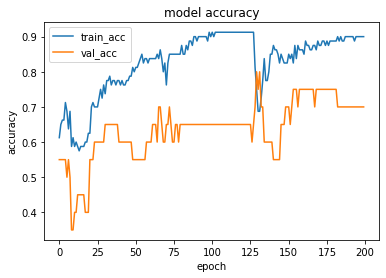

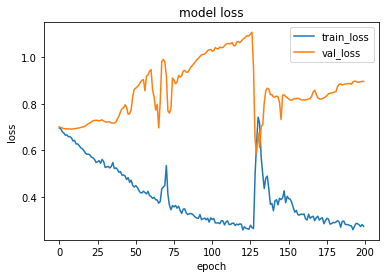

1it [00:00, 17549.39it/s]
file is another_control.mov, prediction is [[0.2934646]]
1it [00:00, 16131.94it/s]
file is short_armflapping.mov, prediction is [[0.10982782]]
1it [00:00, 18893.26it/s]
file is control_far.mov, prediction is [[0.3203961]]
1it [00:00, 14463.12it/s]
file is long_armflapping.mov, prediction is [[0.5931669]]
1it [00:00, 14513.16it/s]
file is me_reading_control.mov, prediction is [[0.30450845]]
1it [00:00, 17050.02it/s]
file is me_armflapping.mov, prediction is [[0.22189146]]
Epoch 1/200
3/3 [==============================] - 0s 152ms/step - loss: 0.6738 - accuracy: 0.5250 - precision_3: 0.4915 - recall_3: 0.7838 - val_loss: 0.6707 - val_accuracy: 0.7000 - val_precision_3: 0.8889 - val_recall_3: 0.6154
Epoch 2/200
3/3 [==============================] - 0s 144ms/step - loss: 0.6719 - accuracy: 0.5875 - precision_3: 0.5400 - recall_3: 0.7297 - val_loss: 0.6696 - val_accuracy: 0.7000 - val_precision_3: 0.8889 - val_recall_3: 0.6154
Epoch 3/200
3/3 [===================

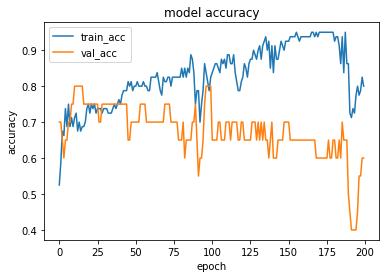

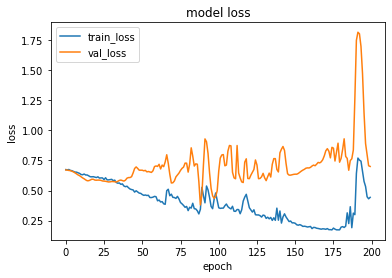

1it [00:00, 17848.10it/s]
file is another_control.mov, prediction is [[0.18024254]]
1it [00:00, 18477.11it/s]
file is short_armflapping.mov, prediction is [[0.8071039]]
1it [00:00, 17260.51it/s]
file is control_far.mov, prediction is [[0.17381972]]
1it [00:00, 16320.25it/s]
file is long_armflapping.mov, prediction is [[0.23552597]]
1it [00:00, 18893.26it/s]
file is me_reading_control.mov, prediction is [[0.15528607]]
1it [00:00, 16912.52it/s]
file is me_armflapping.mov, prediction is [[0.36581993]]
Epoch 1/200
3/3 [==============================] - 0s 162ms/step - loss: 0.6875 - accuracy: 0.6500 - precision_4: 0.6444 - recall_4: 0.7073 - val_loss: 0.6895 - val_accuracy: 0.7000 - val_precision_4: 0.6154 - val_recall_4: 0.8889
Epoch 2/200
3/3 [==============================] - 0s 150ms/step - loss: 0.6828 - accuracy: 0.6750 - precision_4: 0.6667 - recall_4: 0.7317 - val_loss: 0.6860 - val_accuracy: 0.7000 - val_precision_4: 0.6154 - val_recall_4: 0.8889
Epoch 3/200
3/3 [=================

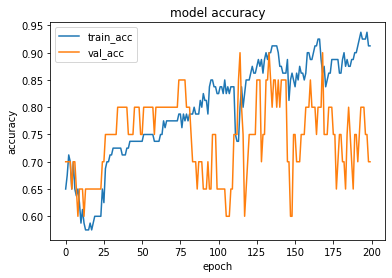

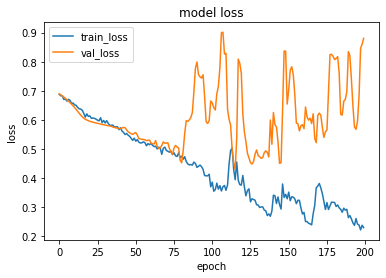

1it [00:00, 15363.75it/s]
file is another_control.mov, prediction is [[0.08140469]]
1it [00:00, 18808.54it/s]
file is short_armflapping.mov, prediction is [[0.87813973]]
1it [00:00, 16710.37it/s]
file is control_far.mov, prediction is [[0.07237369]]
1it [00:00, 20360.70it/s]
file is long_armflapping.mov, prediction is [[0.72585547]]
1it [00:00, 18808.54it/s]
file is me_reading_control.mov, prediction is [[0.23490024]]
1it [00:00, 17189.77it/s]
file is me_armflapping.mov, prediction is [[0.8560046]]
Epoch 1/200
3/3 [==============================] - 0s 160ms/step - loss: 0.7101 - accuracy: 0.4875 - precision_5: 0.4615 - recall_5: 0.1500 - val_loss: 0.6991 - val_accuracy: 0.4000 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 2/200
3/3 [==============================] - 0s 135ms/step - loss: 0.7042 - accuracy: 0.5125 - precision_5: 0.5385 - recall_5: 0.1750 - val_loss: 0.6931 - val_accuracy: 0.6000 - val_precision_5: 0.7500 - val_recall_5: 0.3000
Epoch 3/200
3/3 [=========

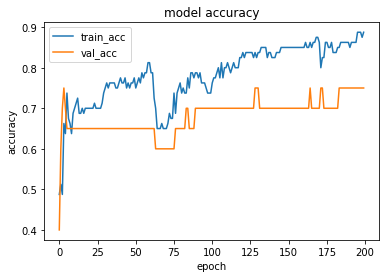

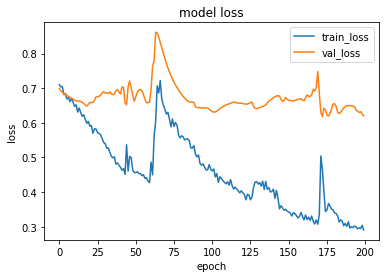

1it [00:00, 16194.22it/s]
file is another_control.mov, prediction is [[0.18887532]]
1it [00:00, 16710.37it/s]
file is short_armflapping.mov, prediction is [[0.84009093]]
1it [00:00, 15887.52it/s]
file is control_far.mov, prediction is [[0.12578642]]
1it [00:00, 12372.58it/s]
file is long_armflapping.mov, prediction is [[0.58916426]]
1it [00:00, 16131.94it/s]
file is me_reading_control.mov, prediction is [[0.19493964]]
1it [00:00, 14513.16it/s]
file is me_armflapping.mov, prediction is [[0.8710181]]
Epoch 1/200
3/3 [==============================] - 0s 147ms/step - loss: 0.7135 - accuracy: 0.5000 - precision_6: 0.4935 - recall_6: 0.9744 - val_loss: 0.7021 - val_accuracy: 0.5500 - val_precision_6: 0.5500 - val_recall_6: 1.0000
Epoch 2/200
3/3 [==============================] - 0s 145ms/step - loss: 0.7036 - accuracy: 0.4875 - precision_6: 0.4875 - recall_6: 1.0000 - val_loss: 0.6970 - val_accuracy: 0.6000 - val_precision_6: 0.6000 - val_recall_6: 0.8182
Epoch 3/200
3/3 [=================

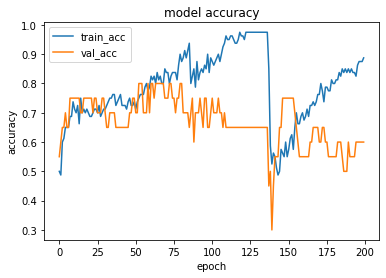

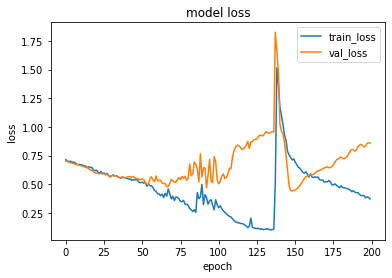

1it [00:00, 14122.24it/s]
file is another_control.mov, prediction is [[0.2853465]]
1it [00:00, 9258.95it/s]
file is short_armflapping.mov, prediction is [[0.9252648]]
1it [00:00, 15650.39it/s]
file is control_far.mov, prediction is [[0.3494196]]
1it [00:00, 14266.34it/s]
file is long_armflapping.mov, prediction is [[0.72616386]]
1it [00:00, 16131.94it/s]
file is me_reading_control.mov, prediction is [[0.2695616]]
1it [00:00, 15141.89it/s]file is me_armflapping.mov, prediction is [[0.7978251]]



In [26]:
def make_model(): 
    model_1 = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(32, return_sequences=False, input_shape = (None, 36)), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    model_1.compile(loss = "binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model_1


checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True)
cross_validate(make_model, epochs = 200, callbacks = [checkpoint])

In [111]:
Z = pd.DataFrame([[1, 1, 0], [1, 2, 0], [1, 0, 0]])
Z[Z == 0] = None
np.mean(Z, axis = 1)

0    1.0
1    1.5
2    1.0
dtype: float64

In [119]:
time_matrix = X[1][1]
new_array = np.zeros((90, 3))
temp_matrix = pd.DataFrame(time_matrix)
temp_matrix[temp_matrix == 0] = None
new_array[:, 0] = np.array(temp_matrix.mean(axis = 1).fillna(0))

In [75]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=False), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_2 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_3 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=False), 
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_4 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False), 
    tf.keras.layers.Dropout(0.3), 
    tf.keras.layers.Dense(1, activation="sigmoid")
])

class acc_Callback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') >= 0.89900):    
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True
            predictions = []
            for file in glob("*.mov"):
                predictions.append(predict_on_video(self.model, file))
            predictions = np.array(predictions).flatten() 
            predictions = np.round_(predictions)
            print(predictions)
            if predictions == np.array([0, 1, 0, 1, 0, 1]): 
                self.model.save("90%_model")
            else: 
                print("not there yet")

accuracy_callback = acc_Callback()

In [19]:
from copy import deepcopy
from tqdm import tqdm 
for z, model in enumerate([model_1, model_2, model_3, model_4]): 
    aug_model = deepcopy(model)
    aug_model.layers.insert(0, Augmenter()) # insert augmentation layer 
    assert model.layers != aug_model.layers

    early_stopping = tf.keras.callbacks.EarlyStopping(patience=15, monitor="val_loss")

    patience = [5, 10]
    
    for i, test_model in enumerate([model, aug_model]):
        for learning_rate in [0.01, 0.001, 0.0005, 0.0001]:
            if z == 0: 
                test_model = tf.keras.models.Sequential([
                    tf.keras.layers.LSTM(64, return_sequences=False, input_shape = (None, 36)), 
                    tf.keras.layers.Dropout(0.2),
                    tf.keras.layers.Dense(1, activation="sigmoid")
                ])
            elif z == 1: 
                test_model = tf.keras.models.Sequential([
                    tf.keras.layers.LSTM(32, return_sequences=False, input_shape = (None, 36)), 
                    tf.keras.layers.Dropout(0.2), 
                    tf.keras.layers.Dense(1, activation="sigmoid")
                ])
            elif z == 2: 
                test_model = tf.keras.models.Sequential([
                    tf.keras.layers.LSTM(64, return_sequences=False, input_shape = (None, 36)), 
                    tf.keras.layers.Dropout(0.3), 
                    tf.keras.layers.Dense(1, activation="sigmoid")
                ])
            else: 
                test_model = tf.keras.models.Sequential([
                    tf.keras.layers.LSTM(32, return_sequences=False, input_shape = (None, 36)), 
                    tf.keras.layers.Dropout(0.3), 
                    tf.keras.layers.Dense(1, activation="sigmoid")
                ])

            test_model.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics = ['accuracy'])    
            print(f"using {['no aug', 'aug'][i]} with lr {learning_rate}")
            try: 
                cross_validate(test_model, epochs = 50, callbacks=[early_stopping, accuracy_callback])
            except Exception as e: 
                print(f"failed training because of {e}")
    print(f"onto model {z + 1}")

SyntaxError: invalid syntax (<ipython-input-19-590b0eb01ea6>, line 22)

In [42]:
def ensemble_val_acc(models, X_test, y_test): 
    y_pred = np.zeros_like(y_test)
    for model in models: 
        y_pred += model.predict(X_test).flatten()
    y_pred = y_pred / len(models)
    y_pred = np.round_(y_pred)
    return (y_pred == y_test).sum() / y_pred.shape[0]